In [25]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os
from control.matlab import *

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["mathtext.fontset"] = "cm"
# plt.rcParams['axes.labelsize']=14
# plt.rcParams['xtick.labelsize']=11
# plt.rcParams['ytick.labelsize']=11
# plt.rcParams['axes.grid']=True
# plt.rcParams['axes.xmargin']=0

In [26]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from dataset_simple_example_1 import SimpleExample1Dataset
import tqdm
import argparse
import metrics

In [27]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [28]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [29]:
# Overall settings
out_dir = "../out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [30]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_controller_simple_example_1.14.pt", map_location=device)

In [31]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [32]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.43M


In [33]:
import pickle as pkl

with open('../../data/control/test_set_simple_example_1_5%_perturbation.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']

In [34]:
import yaml

with open('normalization_params.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
prefilter_key = 'prefilter'
signal_key = 'prbs'
signal_config = config.get(signal_key, {}).get(prefilter_key, {})
e_std = signal_config.get('e_std')
u_std = signal_config.get('u_std')
normalize = True

In [35]:
from utils import *

dtype="float32"
n_context = 500

ts = 1e-2; fs = 1/ts
s = tf('s')
z = tf([1, 0], [1], dt=ts)

# VRFT
s = tf('s')
tau = 1 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = c2d(M, ts, 'matched')
M_proper = z * M

# Specifics for OL experiment
T = 5
t_exp = np.arange(0, T, ts)
t = np.arange(0, n_context*ts, ts)

# To store results
U = np.zeros((len(data_test), n_context))
Y = np.zeros((len(data_test), n_context))
Y_d = np.zeros((len(data_test), n_context))
E = np.zeros((len(data_test), n_context))
R = np.zeros((len(data_test), n_context))

for i, data in enumerate(data_test):
    
    num = [data['num_1']]
    den = [data['den_1'], data['den_2'], data['den_3']]

    G_continuous = tf(num,den)
    G = c2d(G_continuous, ts, 'matched')
    
    if signal_key == "white noise":
        n_steps = np.random.randint(2, 50)
        u = np.random.normal(0, 1000, t_exp.shape)
    elif signal_key == "prbs":
        u = prbs(len(t_exp))
    elif signal_key == "random":
        u = random_signal(len(t_exp))

    y = lsim(G, u, t_exp)[0]
    
    L = M

    if prefilter_key == 'prefilter':
        u_L = lsim(L, u, t)[0]
        y_L = lsim(L, y, t)[0]
    else:
        u_L = u
        y_L = y

    r_v = lsim(M_proper ** (-1), y_L, t_exp)[0]
    e_v = (r_v - y_L)

    u_L = u_L

    # normalize
    if normalize:
        e_v = e_v / e_std
        u_L = u_L / u_std
        
    
    # lunghezza contesto 5
    # start_idx = np.random.randint(500, len(e_v)-n_context)
    start_idx = 0
    e_v = e_v[start_idx:start_idx + n_context] # this is e(t), ... e(t+N)
    u_L = np.insert(u_L, 0, 1e-6)
    u_L = u_L[start_idx:start_idx + n_context] # this is u(t-1), ... u(t+N-1)
    y_L = y_L[start_idx:start_idx + n_context] # this is u(t-1), ... u(t+N-1)
    r_v = r_v[start_idx:start_idx + n_context]
    
    E[i,:] = e_v
    U[i,:] = u_L
    Y[i,:] = y_L
    R[i,:] = r_v
    Y_d[i,:] = lsim(M, r_v, t)[0]
    
E = E.astype(dtype)
U = U.astype(dtype)

In [36]:
batch_e = torch.Tensor(E.reshape(len(data_test),-1,1))
batch_u = torch.Tensor(U.reshape(len(data_test),-1,1))

with torch.no_grad():
    batch_u_pred, loss = model(batch_e, batch_u)

In [37]:
Y_hat = np.zeros((len(data_test), n_context))

for i, data in enumerate(data_test):
    num = [data['num_1']]
    den = [data['den_1'], data['den_2'], data['den_3']]

    G_continuous = tf(num,den)
    G = c2d(G_continuous, ts, 'matched')
    
    Y_hat[i,:] = lsim(G, batch_u_pred[i,:,0] * u_std, np.arange(0, n_context*ts, ts))[0]

<>:6: DeprecationWarning: invalid escape sequence '\h'
<>:16: DeprecationWarning: invalid escape sequence '\h'
<>:24: DeprecationWarning: invalid escape sequence '\h'
<>:6: DeprecationWarning: invalid escape sequence '\h'
<>:16: DeprecationWarning: invalid escape sequence '\h'
<>:24: DeprecationWarning: invalid escape sequence '\h'
/tmp/ipykernel_121396/1472715331.py:6: DeprecationWarning: invalid escape sequence '\h'
  plt.plot(t[:-1], batch_u_pred.detach().numpy()[test_number, :-1, 0] * u_std, label='$\hat{u}$')
/tmp/ipykernel_121396/1472715331.py:16: DeprecationWarning: invalid escape sequence '\h'
  plt.plot(t, Y_hat[test_number,:], label='$\hat{y}$')
/tmp/ipykernel_121396/1472715331.py:24: DeprecationWarning: invalid escape sequence '\h'
  plt.plot(t[:-1], np.abs((batch_u[test_number,1:,0] - batch_u_pred[test_number,:-1,0])*u_std), label='$|u - \hat{u}|$')


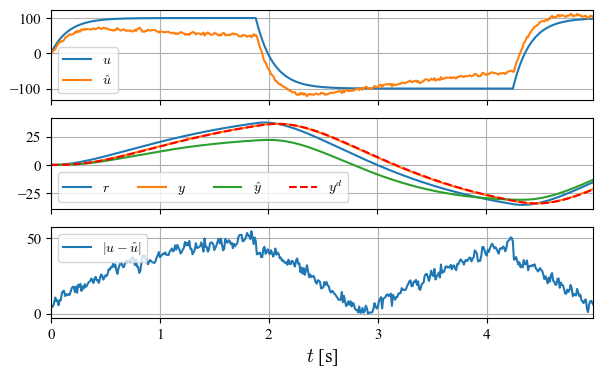

In [38]:
test_number = 0

plt.figure(figsize=(7,4))
plt.subplot(311)
plt.plot(t[:-1], batch_u[test_number, 1:, 0] * u_std, label='$u$')
plt.plot(t[:-1], batch_u_pred.detach().numpy()[test_number, :-1, 0] * u_std, label='$\hat{u}$')
plt.tick_params('x', labelbottom=False)
# plt.xlim([0, 1])
# plt.ylim([-500, 2000])
plt.legend()

plt.subplot(312)
plt.plot(t, R[test_number,:], label='$r$')
# plt.plot(t, y_d, label='$y_d$')
plt.plot(t, Y[test_number,:], label='$y$')
plt.plot(t, Y_hat[test_number,:], label='$\hat{y}$')
plt.plot(t, Y_d[test_number,:], 'r--', label='$y^d$')
plt.tick_params('x', labelbottom=False)
# plt.xlim([0, 0.43])
# plt.ylim([0, 10])
plt.legend(ncols=4)

plt.subplot(313)
plt.plot(t[:-1], np.abs((batch_u[test_number,1:,0] - batch_u_pred[test_number,:-1,0])*u_std), label='$|u - \hat{u}|$')
plt.xlabel("$t$ [s]")
# plt.xlim([0, 0.43])
# plt.ylim([0, 4])
plt.legend()

plt.show()

In [39]:
print('e:', batch_e[0, :5, 0])
print('u:', batch_u[0, :6, 0])
print('u_hat:', batch_u_pred[0, :5, 0])
print('y:', Y[0, :5])
print('r:', R[0, :5])

SyntaxError: invalid syntax (2701612772.py, line 2)

In [ ]:
0.3264*175.1

In [ ]:
# test_ds = SimpleExample1Dataset(seq_len=seq_len, normalize=True, return_y=True)
# test_dl = DataLoader(test_ds, batch_size=batch_size)

In [ ]:
# Prediction
# batch_u, batch_e, batch_y, batch_r = next(iter(test_dl))
with torch.no_grad():
    batch_u_pred, loss = model(batch_e, batch_u)

In [ ]:
plt.figure()
#plt.plot(batch_input[0,:,0])
ts = 1e-2
T = batch_e.shape[1]*ts  # ts*self.seq_len# * 2
t = np.arange(0, T, ts)

for i in range(batch_size):
    plt.subplot(211)
    plt.plot(t, batch_e[i, :, 0], c='tab:blue', alpha=0.2)
    plt.legend(['$e_v$'])
    plt.subplot(212)
    plt.plot(t, batch_u[i, :, 0], c='tab:blue', alpha=1)
    plt.plot(t, batch_u_pred.detach().numpy()[i, :, 0], c='tab:orange', alpha=1)
    plt.legend(['$u$'])
    plt.xlabel("$t$ [s]")
    # plt.xlim([2.7, 2.9])
plt.show()

In [ ]:
plt.plot(t, batch_r[0,:,0].T)

In [ ]:
s = tf('s')
z = tf([1, 0], [1], dt=ts)

# VRFT
s = tf('s')
tau = 1 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = c2d(M, ts, 'matched')

y_d = lsim(M, batch_r[0,:,0], t)[0]

In [ ]:
plt.subplot(311)
plt.plot(t[:-1], batch_u[0, 1:, 0] * 175.1, label='$u$')
plt.plot(t[:-1], batch_u_pred.detach().numpy()[0, :-1, 0] * 175.1, label='$\hat{u}$')
# plt.xlim([0, 0.43])
# plt.ylim([-500, 2000])
plt.legend()
plt.subplot(312)
plt.plot(t, batch_r[0,:,0], label='$r$')
plt.plot(t, y_d, label='$y_d$')
plt.plot(t, batch_y[0,:,0], label='$y$')
# plt.plot(t, y_hat, label='$\hat{y}$')
# plt.xlim([0, 0.43])
# plt.ylim([0, 10])
plt.legend()
plt.subplot(313)
plt.plot(t, batch_r[0,:,0] - batch_y[0,:,0], label='$e$')
plt.plot(t, batch_e[0,:,0] * 4.8320, label=r'$\tilde{e}$')
# plt.xlim([0, 0.43])
# plt.ylim([0, 4])
plt.legend()
plt.show()

In [ ]:
from control.matlab import *

data = dict()

data['num_1'] = np.float32(1)
data['den_1'] = np.float32(1)
data['den_2'] = np.float32(3)
data['den_3'] = np.float32(2)


num = [data['num_1']]
den = [data['den_1'], data['den_2'], data['den_3']]

s = tf('s')
G = tf(num, den)
y_hat, _, _ = lsim(G, batch_u_pred[0,:,0] * 175.1, t)
e_hat = batch_r[0,:,0] - y_hat

In [ ]:
plt.subplot(311)
plt.plot(t[:-1], batch_u[0, 1:, 0] * 175.1, label='$u$')
plt.plot(t[:-1], batch_u_pred.detach().numpy()[0, :-1, 0] * 175.1, label='$\hat{u}$')
# plt.xlim([0, 0.43])
# plt.ylim([-500, 2000])
plt.legend()
plt.subplot(312)
plt.plot(t, batch_r[0,:,0], label='$r$')
plt.plot(t, batch_y[0,:,0], label='$y$')
plt.plot(t, y_hat, label='$\hat{y}$')
# plt.xlim([0, 0.43])
# plt.ylim([0, 10])
plt.legend()
plt.subplot(313)
plt.plot(t, batch_r[0,:,0] - batch_y[0,:,0], label='$e$')
plt.plot(t, batch_e[0,:,0] * 4.8320, label=r'$\tilde{e}$')
# plt.xlim([0, 0.43])
# plt.ylim([0, 4])
plt.legend()
plt.show()

In [ ]:
plt.subplot(211)
plt.plot(t[:-1], np.abs((batch_u[0, 1:, 0] - batch_u_pred.detach().numpy()[0, :-1, 0]) * 118.5), label='$|u - \hat{u}|$')
plt.legend()

plt.subplot(212)
plt.plot(t, np.abs((batch_e[0,:,0] - e_hat)), label='$|e - \hat{e}|$')
plt.legend()
plt.show()